In [1]:
import pandas as pd
df=pd.read_csv("/content/final_data (1).csv")
print(df)

     Unnamed: 0                                           Original  \
0             0  Chinese cleavers have wide and flat blades, us...   
1             1  Chinese cleavers have wide and flat blades, us...   
2             2  Chinese cleavers have wide and flat blades, us...   
3             3  Chinese cleavers have wide and flat blades, us...   
4             4  Hamilton Beach FlexBrew Single Serve Coffee Ma...   
..          ...                                                ...   
455         455  Without a steady income, Susi had to dip into ...   
456         456  Without a steady income, Susi had to dip into ...   
457         457  Without a steady income, Susi had to dip into ...   
458         458  Without a steady income, Susi had to dip into ...   
459         459  Without a steady income, Susi had to dip into ...   

                                           Paraphrases  
0    Chinese cleavers are known for their flat, wid...  
1    Western-thick blades with a minimum leng

In [2]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp=spacy.load("en_core_web_lg")



def get_entities(text):
  entset=set([X.text for X in nlp(text).ents if X.label_ in ['GPE', 'LOC']])
  return[ent for ent in entset]


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
column_list = df['Paraphrases'].tolist()

In [5]:
def mask_occurrences(sentence, target_word):

    indices = [i for i in range(len(sentence)) if sentence.startswith(target_word, i)]

    if not indices:
        return [sentence]

    masked_sentences = [sentence[:i] + "<mask>" + sentence[i + len(target_word):] for i in indices]

    return masked_sentences

In [17]:
data_masked=[]
for sent in column_list:
  entities=get_entities(sent)
  if(len(entities)>0):
    for ent in entities:
      res = mask_occurrences(sent, ent)
      for r in res:
        data_masked.append([sent,r])


In [10]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model="studio-ousia/luke-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
gen_list = []
punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
for s in data_masked:
    results = unmasker(s[1],top_k=3)
    temp=([result['sequence'] for result in results if result['token_str'] not in punc])
    for t in temp:
      gen_list.append([s[0],t])


In [22]:
for result in gen_list:
  print(result)

['Stone was a resident of Long Island for 19 years and passed away in 2019 at the age of 94.', 'Stone was a resident of Springfield for 19 years and passed away in 2019 at the age of 94.']
['Stone was a resident of Long Island for 19 years and passed away in 2019 at the age of 94.', 'Stone was a resident of Huntington for 19 years and passed away in 2019 at the age of 94.']
['Stone was a resident of Long Island for 19 years and passed away in 2019 at the age of 94.', 'Stone was a resident of Houston for 19 years and passed away in 2019 at the age of 94.']
["It was also noted that Berkshire's cash holding has now hit $128 billion, as per his statement.", "It was also noted that Trump's cash holding has now hit $128 billion, as per his statement."]
["It was also noted that Berkshire's cash holding has now hit $128 billion, as per his statement.", "It was also noted that Buffett's cash holding has now hit $128 billion, as per his statement."]
["It was also noted that Berkshire's cash hold

In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

def paraphrase(
    question,
    num_beams=4,
    num_beam_groups=4,
    num_return_sequences=1,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids

    outputs = model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return res


In [ ]:
tolabel=[]
for s in gen_list:
  changed=paraphrase(s[1])
  tolabel.append([s[0],changed])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [30]:
print(len(gen_list))

425


In [32]:
for unlabelled in tolabel:
  print(unlabelled)

['Stone was a resident of Long Island for 19 years and passed away in 2019 at the age of 94.', ['In 2019, Stone died at the age of 94, having lived in Springfield for 19 years.']]
['Stone was a resident of Long Island for 19 years and passed away in 2019 at the age of 94.', ['Having lived in Huntington for 19 years, Stone passed away at the age of 94 in 2019.']]
['Stone was a resident of Long Island for 19 years and passed away in 2019 at the age of 94.', ['In 2019, Stone died at the age of 94, having lived in Houston for 19 years.']]
["It was also noted that Berkshire's cash holding has now hit $128 billion, as per his statement.", ['Trump also mentioned that his cash holdings have reached $128 billion.']]
["It was also noted that Berkshire's cash holding has now hit $128 billion, as per his statement.", ['Buffett also said his cash holdings now stand at $128 billion.']]
["It was also noted that Berkshire's cash holding has now hit $128 billion, as per his statement.", ["He stated tha

In [33]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

def check_entailment(query, text):
  tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')
  model = RobertaForSequenceClassification.from_pretrained('roberta-large-mnli')
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  inputs = tokenizer.encode_plus(query, text, add_special_tokens=True, padding='longest', truncation=True, return_tensors='pt')
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    entailment_score = probabilities[:, 1].item()

  return entailment_score


In [36]:
labelled_data=[]
for data in tolabel:
  score=check_entailment(data[0],data[1])
  labelled_data.append([data[0],data[1],score])

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another tas

In [50]:
col3data=[]
for data in labelled_data:
  col3data.append(data[2])
print(col3data)
import numpy as np
p75 = np.percentile(col3data, 75)
p25 = np.percentile(col3data, 25)
p50 = np.percentile(col3data, 50)
labels=['refute','neutral''support']
getlabels=['refute' if score <= p25 else 'neutral' if score >=p25 and score <= p75  else 'support' for score in col3data]
print(getlabels)

[0.23674100637435913, 0.23674100637435913, 0.23674100637435913, 0.3431568443775177, 0.3431568443775177, 0.3431568443775177, 0.2626836895942688, 0.2626836895942688, 0.2626836895942688, 0.29360970854759216, 0.29360970854759216, 0.29360970854759216, 0.29360970854759216, 0.29360970854759216, 0.29360970854759216, 0.30534079670906067, 0.30534079670906067, 0.30534079670906067, 0.30534079670906067, 0.30534079670906067, 0.30534079670906067, 0.3101021945476532, 0.3101021945476532, 0.3101021945476532, 0.3101021945476532, 0.3101021945476532, 0.3101021945476532, 0.2738504707813263, 0.2738504707813263, 0.2738504707813263, 0.2745327353477478, 0.2745327353477478, 0.2745327353477478, 0.2745327353477478, 0.2745327353477478, 0.2745327353477478, 0.2663860321044922, 0.2663860321044922, 0.2663860321044922, 0.2893306314945221, 0.2893306314945221, 0.2893306314945221, 0.3083594739437103, 0.3083594739437103, 0.3083594739437103, 0.3083594739437103, 0.3083594739437103, 0.3083594739437103, 0.3083594739437103, 0.30

In [51]:
final_labelled=[]
for data,tag in zip(labelled_data,getlabels):
  final_labelled.append([data[0],data[1],tag])


In [56]:
csv_file="GE_data"
import pandas as pd
df = pd.DataFrame((final_labelled), columns=["Sentence", "Comparison","Score"])
print(df)
import csv

custom_header = ["Sentence", "Comparison","Score"]
df.columns = custom_header


df.to_csv(csv_file, index=True)

                                              Sentence  \
0    Stone was a resident of Long Island for 19 yea...   
1    Stone was a resident of Long Island for 19 yea...   
2    Stone was a resident of Long Island for 19 yea...   
3    It was also noted that Berkshire's cash holdin...   
4    It was also noted that Berkshire's cash holdin...   
..                                                 ...   
420  In a game where Mahomes and the Chiefs' offens...   
421  In a game where Mahomes and the Chiefs' offens...   
422  In a game where Mahomes and the Chiefs' offens...   
423  In a game where Mahomes and the Chiefs' offens...   
424  In a game where Mahomes and the Chiefs' offens...   

                                            Comparison    Score  
0    [In 2019, Stone died at the age of 94, having ...   refute  
1    [Having lived in Huntington for 19 years, Ston...   refute  
2    [In 2019, Stone died at the age of 94, having ...   refute  
3    [Trump also mentioned that his cas

In [57]:

from google.colab import files
files.download('GE_labelled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

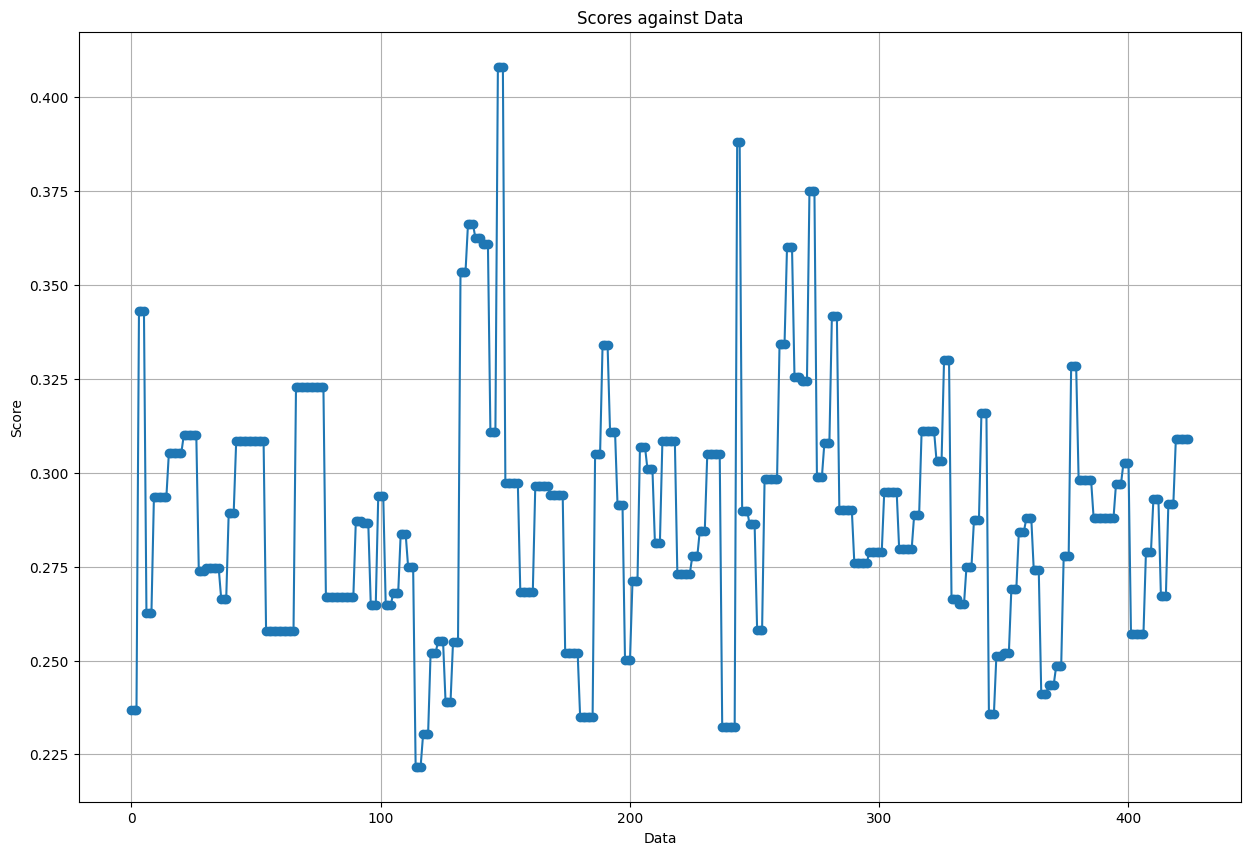

In [59]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(col3data))
plt.figure(figsize=(15,10))
plt.plot(x, col3data, marker='o', linestyle='-')

plt.title('Scores against Data')
plt.xlabel('Data')
plt.ylabel('Score')

plt.grid(True)
plt.show()




